# Bicycle Networks
Luis G. Natera Orozco

Scientific Python Fall 2017

Final Project

***
For the final project I worked with cycleway networks, using the python library OSMnx to download data from open street map and convert it to a network object.
The main goal was to analyse the how complete the network is, in order to do this I did the following:

1. Get the data from open street map and generate a network.
2. Plot the street infraestucture that is contained in the network (types of streets)
3. Plot the possible walking and biking distances from the centermost node.
4. Get the cycleways network
    4.1. Plot the cycleways network
    4.2. Plot the possible walking and biking distances using only the cycleways network
5. Compare the two networks in terms of kilometers 
6. Plot the cycleways network over the general network
7. Calculate the cycleway kilometers for every weakly connected component in the cycleway network
8. Get the basic statistics (OSMnx) for every weakly connected component.




### Import all the libraries I will be using

In [1]:
import time
import collections
import numpy as np
import osmnx as ox
import pandas as pd
import networkx as nx 
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from shapely.geometry import Point
from descartes import PolygonPatch
from collections import Counter

%matplotlib inline

Configure OSMnx parameters.

In [2]:
ox.config(data_folder='data', logs_folder='logs', 
          imgs_folder='imgs', cache_folder='cache', 
          use_cache=True, log_file=True, log_console=True)

### 1. Get the data from open street map and generate a network

***
Using OSMnx get the data from any city especified on the variable "place" and constuct a network from it.

In [3]:
start_time = time.time()
place = 'Amsterdam, Netherlands'
city = 'Amsterdam' # City name to save the figures with
G = ox.graph_from_place(place, network_type='all', simplify=True, which_result=2)
G = ox.project_graph(G)

print("    Data processed in:\n--- %s seconds ---" % (time.time() - start_time))

    Data processed in:
--- 638.1351211071014 seconds ---


#### Function to plot a network and save it
Plot the network of intersections (nodes) and streets (edges) and save the image as a PNG

In [4]:
def plot_cityNetwork (G, net_type):
    fig, ax = ox.plot_graph(G, node_size=1, node_zorder=2, 
                            edge_linewidth=0.6, edge_color='k', 
                            edge_alpha=0.2,  
                            )
    fig.savefig('imgs/'+city+'_01_'+net_type+'.png', dpi=300)

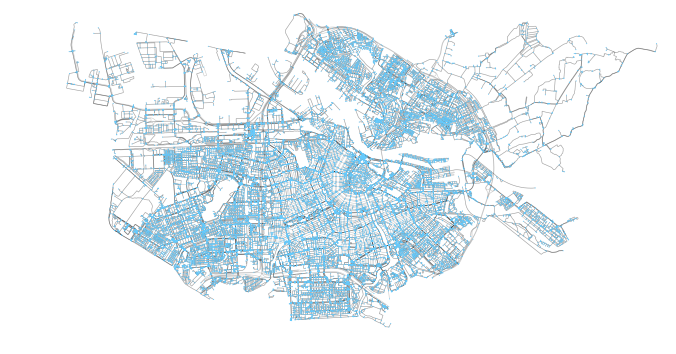

In [5]:
plot_cityNetwork(G, 'StreetNetwork')

### 2.- Plot the street infraestructure of the city 
***
The data returned from OSMnx includes the type of every street, this is a key element to analyse in order to know how many types of streets a city have and how does the bicycle infraestructure compares to the other types of streets in the network.

The next function takes the graph and iterates over all the edges and count how many times each type of street is in the network, then plots the data in a bar chart.

In [6]:
def street_types(G):
    '''
    Count and plot all the different types of street types that are in the network.
    '''
    
    # Use a list to store all the types of streets that are inside the edges (streets)
    streets = []
    edges = dict(G.edges)
    for k, v in edges.items():                        # Iterate over the dictionary
        if isinstance(v['highway'], list):            # If the value of the highway is a list then I have to iterate over all the items
            for s in v['highway']:
                streets.append(s)
        else:
            streets.append(v['highway'])
            
    #Count the types of streets
    streets_count = Counter(streets)   
    streets_dic = collections.OrderedDict(sorted(streets_count.items()))
    streets_val = list(streets_dic.values())
    streets_type =list(streets_dic.keys())

    # Plot the street distribution
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_xlabel('Streets', fontsize=20)
    ax.set_ylabel('# Streets', fontsize=20)
    ax.set_title('Street infraestructure '+ place, fontsize=25)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.bar(streets_type, streets_val, color = '#474444')

    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
        tick.set_fontsize(13)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(13)
        
    fig.savefig('imgs/'+city+'_03Street_Type.png', dpi=300)

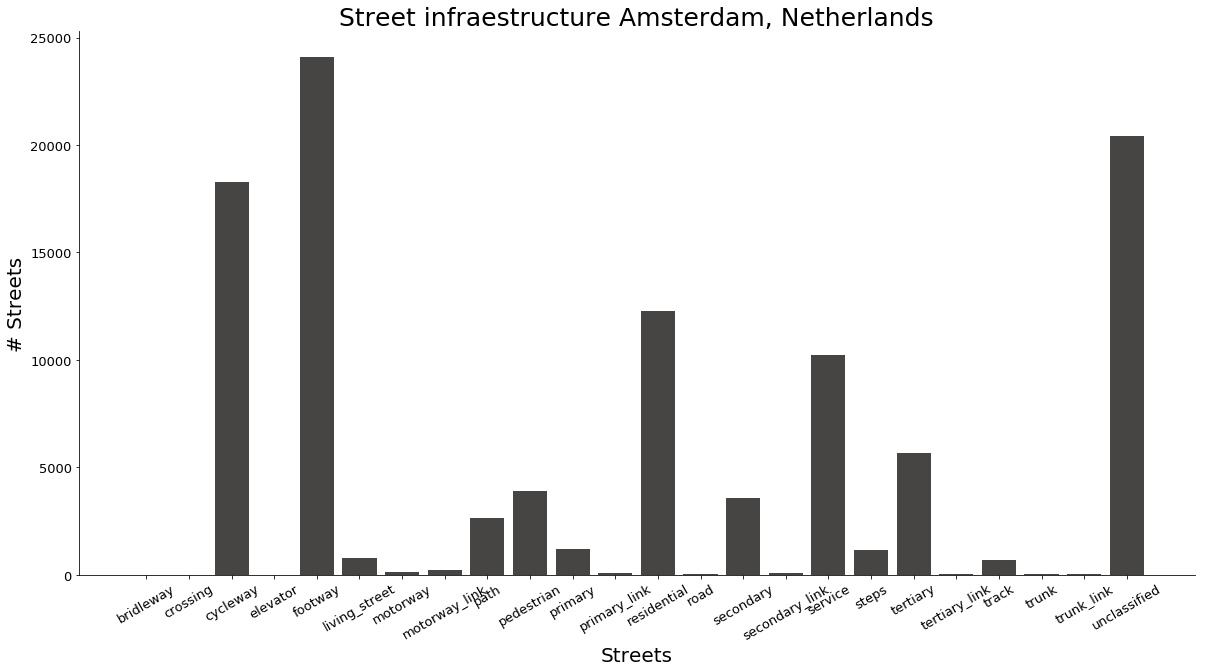

In [7]:
street_types(G)

### 3.- Plot the posible travel distances from the centermost node
***
I used some base code from OSMnx and write a function to compute the travel times and plot them using an isochrone to visualise how far someone can walk and bike in any city, taking the centermost node of the graph as the starting point.

To do so the algorithm has to:

1. Set the travel time and speed for pedestrians and bikes.
2. Find the centermost node and project a copy of the graph to UTM
3. Add an edge atribute for the time, in minutes, required to traverse each edge
4. Get colors for the isochrone
5. Color the nodes and plot the network

In [6]:
def plot_travel(G, net_type):
    '''
    Plot the walking and biking isochrone for a network.
    '''
    # 1. Set the travel time and speed for pedestians and bikes.
    trip_times_pedestrian = [5, 10, 15, 20] 
    travel_speed_pedestrian = 4.5 
    trip_times_bike = [5, 10, 15, 20, 30] 
    travel_speed_bike = 15 
    
    
    # 2. Find the centermost node and then project the graph to UTM
    gdf_nodes = ox.graph_to_gdfs(G, edges=False)
    x, y = gdf_nodes['geometry'].unary_union.centroid.xy
    center_node = ox.get_nearest_node(G, (y[0], x[0]))
    # 2.1 Create a copy of the graph to work with the pedestrian and bike networks
    G_pedestrians = ox.project_graph(G)
    G_bikes = ox.project_graph(G)
    
    
    # 3.1. Add an edge attribute for time in minutes required to traverse each edge for pedestrians
    meters_per_minute_pedestrian = travel_speed_pedestrian * 1000 / 60 #km per hour to m per minute
    for u, v, k, data in G_pedestrians.edges(data=True, keys=True):
        data['time'] = data['length'] / meters_per_minute_pedestrian  
    # 3.2. Add an edge attribute for time in minutes required to traverse each edge for bicycles
    meters_per_minute_bike = travel_speed_bike * 1000 / 60 #km per hour to m per minute
    for u, v, k, data in G_bikes.edges(data=True, keys=True):
        data['time'] = data['length'] / meters_per_minute_bike
    
    
    # 4.1 Get one color for each isochrone for pedestrians
    iso_colors_pedestrian = ox.get_colors(n=len(trip_times_pedestrian), cmap='inferno', start=0.3, return_hex=True)
    # 4.2 Get one color for each isochrone for bikes
    iso_colors_bike = ox.get_colors(n=len(trip_times_bike), cmap='inferno', start=0.3, return_hex=True)
    
 

 # make the isochrone polygons
    isochrone_polys_pedestrian = []
    for trip_time in sorted(trip_times_pedestrian, reverse=True):
        subgraph_pedestrian = nx.ego_graph(G_pedestrians, center_node, radius=trip_time, distance='time')
        node_points_pedestrian = [Point((data['x'], data['y'])) for node, data in subgraph_pedestrian.nodes(data=True)]
        bounding_poly_pedestrian = gpd.GeoSeries(node_points_pedestrian).unary_union.convex_hull
        isochrone_polys_pedestrian.append(bounding_poly_pedestrian)

    # plot the network then add isochrones as colored descartes polygon patches
    fig, ax = ox.plot_graph(G_pedestrians, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, edge_linewidth=0.6,  node_color='none',save=place+'_walk')
    for polygon, fc in zip(isochrone_polys_pedestrian, iso_colors_pedestrian):
        patch_pedestrian = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch_pedestrian)
    plt.show()
    fig.savefig('imgs/'+city+'_02WalkingDistance_'+net_type+'.png', dpi=300)
    
    
        
    # make the isochrone polygons
    isochrone_polys_bike = []
    for trip_time in sorted(trip_times_bike, reverse=True):
        subgraph_bike = nx.ego_graph(G_bikes, center_node, radius=trip_time, distance='time')
        node_points_bike = [Point((data['x'], data['y'])) for node, data in subgraph_bike.nodes(data=True)]
        bounding_poly_bike = gpd.GeoSeries(node_points_bike).unary_union.convex_hull
        isochrone_polys_bike.append(bounding_poly_bike)
    
    
    # plot the network then add isochrones as colored descartes polygon patches
    fig, ax = ox.plot_graph(G_bikes, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, edge_linewidth=0.6, node_color='none')
    for polygon, fc in zip(isochrone_polys_bike, iso_colors_bike):
        patch_bike = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch_bike)
    plt.show()
    fig.savefig('imgs/'+city+'_02_BikingDistance_'+net_type+'.png', dpi=300)


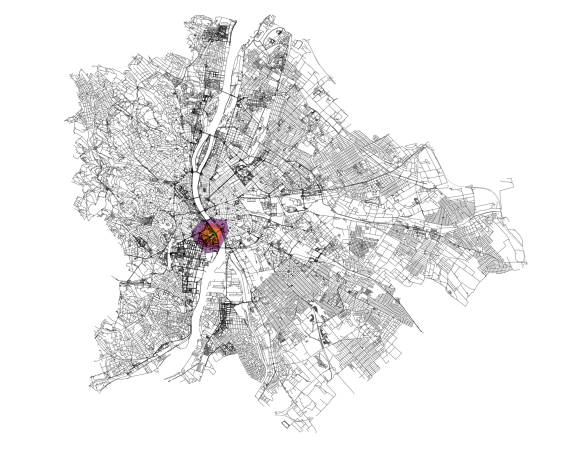

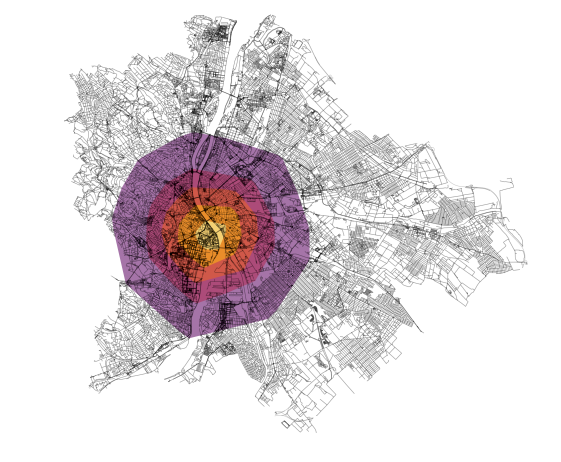

In [7]:
plot_travel(G, 'Streets')

### 4.- Get the bicycle network
***
OSMnx returns all the street where a bike can travel, and we are interested in the routes designed only for bicycles.

I used a funtion to iterate over all the edges of the graph (streets) and look for all of those that are not a cycleway, then remove those edges, calculate the degree of the nodes and remove those that weren't connected. This returns a new graph that only have cycleways and nodes that are connected, and plot the network of cycleways.

In [8]:
def bike_network(G):
    cycle = []
    remove = []
    
    G_cycle = G.copy(as_view=False) #Copy the network to a new one to keep the city as reference
    edges = dict(G_cycle.edges)
    
    
    for k, v in edges.items():
        if (v['highway']) !='cycleway':
                cycle.append(k)
        elif isinstance(v['highway'], list):
            for s in v['highway']:
                if s != 'cycleway':
                    cycle.append(k)
                    
    for c in cycle:
        u,v,w = c
        G_cycle.remove_edge(u,v)
    
    degree = list(G_cycle.degree())
    
    for k in degree:
        n,v = k
        if v == 0:
            remove.append(n)
        
    G_cycle.remove_nodes_from(remove)
    
    plot_cityNetwork(G_cycle, 'CyclewayNetwork')
    
    return G_cycle

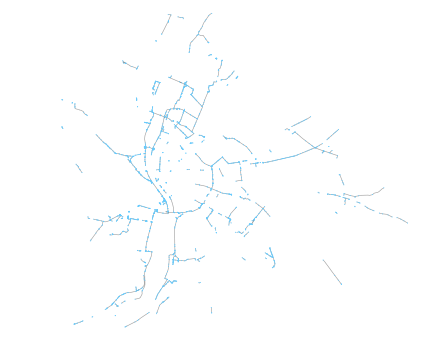

In [11]:
G_cycle = bike_network(G)

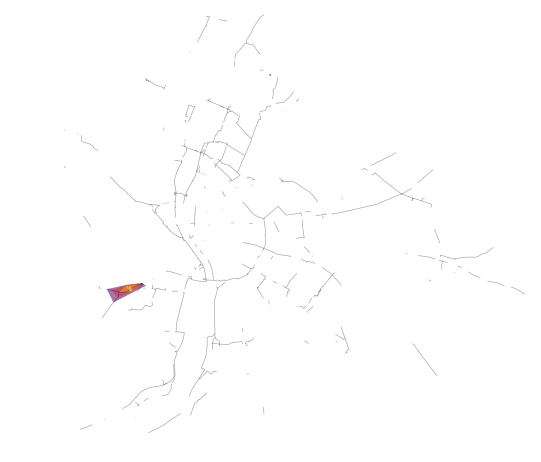

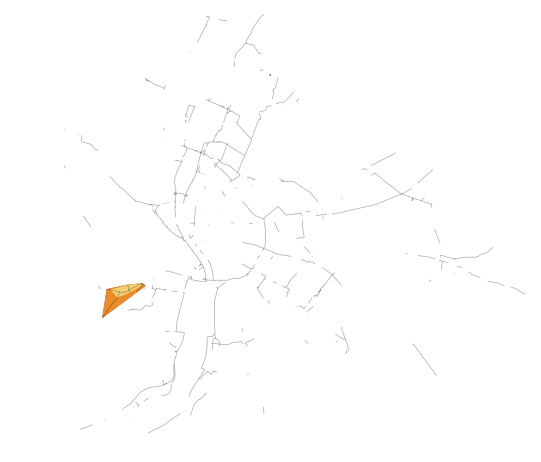

In [12]:
plot_travel(G_cycle, 'Cycleways')

### 5.- Compare Networks
***
The next function compares the two networks (Cycleways and Streets) and returns the total of Kilometers for each one and the coverage percentage of the cycleways network.

In [13]:
def compare_networks(G, G_cycle):
    km_networks = []
    networks = ['Streets and other infraestructure', 'Cycleways']
    G_stats = ox.basic_stats(G)
    G_cycle_stats = ox.basic_stats(G_cycle)
    
    km_networks.append(G_stats['edge_length_total']/1000)
    km_networks.append(G_cycle_stats['edge_length_total']/1000)

    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_ylabel('Km', fontsize=10)
    ax.set_title('Km of infraestructure in '+ city, fontsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.bar(networks,km_networks, color = '#252525')

    for tick in ax.get_xticklabels():
        tick.set_fontsize(10)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(10)
        
    fig.savefig('imgs/'+city+'_03_KmInfraestructure.png', dpi=300)
    
    print ('Km of streets: ' + str(G_stats['edge_length_total']/1000))
    print ('Km of cycleways: ' + str(G_cycle_stats['edge_length_total']/1000))
    
    percentage_cover = ((G_cycle_stats['edge_length_total']/1000)/(G_stats['edge_length_total']/1000))*100
    print ('The cycleway network of {!r} covers {!r}% of the whole infraestructure network'.format(city, round(percentage_cover)))

Km of streets: 5887.408295872152
Km of cycleways: 1040.4708026489939
The cycleway network of 'Amsterdam' covers 18% of the whole infraestructure network


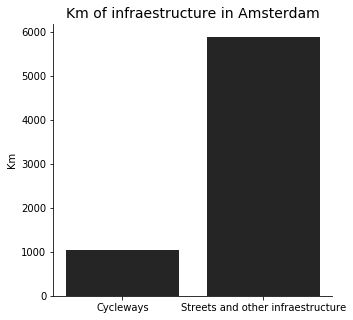

In [14]:
compare_networks(G, G_cycle)

### 6.- Plot over
***
For a better understanding of how complet or incomplete the cycleway network is I plotted the cycleways, changing the colors of the edges, to visualise them in relation to the complete street network.

In [9]:
def plot_over(G):

    color=[]
    width=[]
    edges = dict(G.edges)
    for k, v in edges.items():
            if (v['highway']) !='cycleway':
                    color.append('#bdbdbd')
                    width.append(0.5)
            elif isinstance(v['highway'], list):
                for s in v['highway']:
                    if s != 'cycleway':
                        color.append('#bdbdbd')
                        width.append(0.5)
                    else:
                        color.append('r')
                        width.append(1)
            else:
                color.append('r')
                width.append(1)

    fig, ax = ox.plot_graph(G, node_size=0, node_zorder=2, 
                                edge_linewidth=width, edge_color=color, 
                                edge_alpha=0.5,  
                                )
    fig.savefig('imgs/'+city+'_01_'+'CyclewaysOverStreets.png', dpi=300)


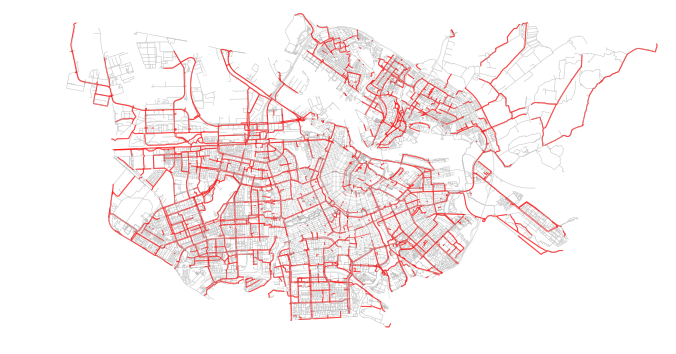

In [10]:
plot_over(G)

### 7.- Size weakly connected components
***
One key measure to understand if the cycleway network is complete is to look at the weakly connected components and plot how many kilometers of cycleways each have.

In [19]:
def weakly_sizes(G):
    

    wcc = list(nx.weakly_connected.weakly_connected_component_subgraphs(G))
    print (len(wcc))

    lenghts = []
    Nodes = []
    Network = []
    N = 0
    for cc in wcc:
        edges = dict(cc.edges)
        distance = [v['length'] for k, v in edges.items()]
        lenghts.append(sum(distance)/1000)
        Nodes.append(len(cc.nodes))
        Network.append(N)
        N = N+1

    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_ylabel('Cycleway Km in Subgraph', fontsize=20)
    ax.set_xlabel('Weakly connected components', fontsize=20)
    ax.set_title('Cycleway Km for weakly connected components in '+ city, fontsize=25)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.text(N-10,min(lenghts)+1, '{!r} cycleway km\n{!r} subgraphs'.format(round(sum(lenghts)),N), fontsize=15, withdash=True)

    plt.bar(Network,(sorted(lenghts, reverse=True)), color = '#252525')

    for tick in ax.get_xticklabels():
        tick.set_fontsize(10)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(10)

    fig.savefig('imgs/'+city+'_03_KmWeaklyCC.png', dpi=300)
    
    return wcc


141


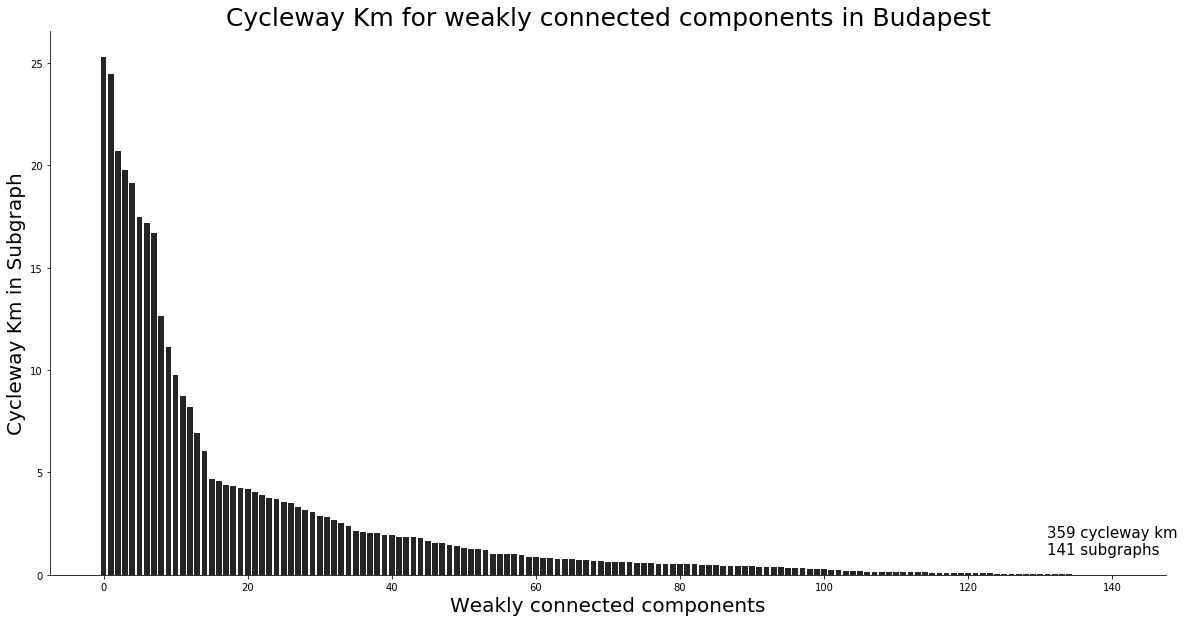

In [20]:
wcc = weakly_sizes(G_cycle)

### 8.- Basic measures for every weakly connected component
***
To later continue with the analysis of every weakly connected component I calculate the basic statistics of each network and store them in a data frame that is saved in a csv file and returned in the function.

In [23]:
def basic_stats(wcc):
    rows = []


    wcc_id = 0

    for cc in wcc:
        stats = ox.basic_stats(cc)
        row = {}
        row['id'] = wcc_id
        row['Nodes'] = stats['n']
        row['Edges'] = stats['m']
        row['streets_per_node_avg'] = stats['streets_per_node_avg']
        row['intersect_count'] = stats['intersection_count'] 
        row['k_avg'] = stats['k_avg']
        row['total km in network'] = stats['edge_length_total']/1000
        row['Street_avg_length'] = stats['edge_length_avg']
        rows.append(row)
        wcc_id = wcc_id+1

    df = pd.DataFrame(rows)
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('id')))
    df = df.reindex(columns=cols)
    df.to_csv('data/{!r}.csv'.format(city), encoding='utf-8', index=False)
    
    return df


In [26]:
basic_stats(wcc)

,id,Edges,Nodes,Street_avg_length,intersect_count,k_avg,streets_per_node_avg,total km in network
0,0,14332,9371,56.020038,9343,3.058798,13.236581,802.879191
1,1,7,6,33.843876,6,2.333333,20673.333333,0.236907
2,2,2,2,46.739289,2,2.000000,62020.000000,0.093479
3,3,10,6,79.200602,6,3.333333,20673.333333,0.792006
4,4,1612,876,55.429342,876,3.680365,141.598174,89.352100
5,5,46,22,307.256986,22,4.181818,5638.181818,14.133821
6,6,6,4,19.395415,4,3.000000,31010.000000,0.116372
7,7,72,37,213.074820,37,3.891892,3352.432432,15.341387
8,8,4,3,112.615668,3,2.666667,41346.666667,0.450463
9,9,2,2,29.830642,2,2.000000,62020.000000,0.059661
